# Simple dynamic seq2seq with TensorFlow

Potapov Anatoly MIPT student

based on https://github.com/ematvey/tensorflow-seq2seq-tutorials/blob/master/1-seq2seq.ipynb

also some recepies from http://web.stanford.edu/class/cs20si

In [1]:
# For saving checkpoints.
model_name = 'basic_seq2seq'

## Task:

Problem 3
(difficult!)

Write a sequence-to-sequence LSTM which mirrors all the words in a sentence. For example, if your input is:
  
    the quick brown fox
  
the model should attempt to output:
 
    eht kciuq nworb xof
 
Refer to the lecture on how to put together a sequence-to-sequence model, as well as this article for best practices.

In [2]:
# These are all the modules we'll be using later.
from __future__ import print_function
import os
import numpy as np
import random
import string
import tensorflow as tf
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve

## Load text corpus

In [3]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """
    Download a file if not present, and make sure it's the right size.
    """

    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


## Read data into memory

In [4]:
def read_data(filename):
    f = zipfile.ZipFile(filename)
    for name in f.namelist():
        return tf.compat.as_str(f.read(name))
    f.close()

text = read_data(filename)
print('Data size %d' % len(text))

Data size 100000000


# Model

Here we implement plain seq2seq — forward-only encoder + decoder without attention.  [Sutskever, Vinyals and Le (2014)](https://arxiv.org/abs/1409.3215). 

Architecture diagram from their paper:
![seq2seq architecutre](pictures/1-seq2seq.png)
Rectangles are encoder and decoder's recurrent layers. Encoder receives `[A, B, C]` sequence as inputs. We don't care about encoder outputs, only about the hidden state it accumulates while reading the sequence. After input sequence ends, encoder passes its final state to decoder, which receives `[<EOS>, W, X, Y, Z]` and is trained to output `[W, X, Y, Z, <EOS>]`. `<EOS>` token is a special word in vocabulary that signals to decoder the beginning of translation.

## Implementation details

TensorFlow has its own [implementation of seq2seq](https://www.tensorflow.org/tutorials/seq2seq/). Recently it was moved from core examples to [`tensorflow/models` repo](https://github.com/tensorflow/models/tree/master/tutorials/rnn/translate), and uses deprecated seq2seq implementation. Deprecation happened because it uses **static unrolling**.

**Static unrolling** involves construction of computation graph with a fixed sequence of time step. Such a graph can only handle sequences of specific lengths. One solution for handling sequences of varying lengths is to create multiple graphs with different time lengths and separate the dataset into this buckets.

**Dynamic unrolling** instead uses control flow ops to process sequence step by step. In TF this is supposed to more space efficient and just as fast. This is now a recommended way to implement RNNs.

## Vocabulary

Seq2seq maps sequence onto another sequence. Both sequences consist of integers from a fixed range. In language tasks, integers usually correspond to words: we first construct a vocabulary by assigning to every word in our corpus a serial integer. First few integers are reserved for special tokens. We'll call the upper bound on vocabulary a `vocabulary size`.

Input data consists of sequences of integers.
In our task integers correspond to chars.

# Building a model

## Simple seq2seq

Encoder starts with empty state and runs through the input sequence. We are not interested in encoder's outputs, only in its `final_state`.

Decoder uses encoder's `final_state` as its `initial_state`. Its inputs are a batch-sized matrix with `<EOS>` token at the 1st time step and `<PAD>` at the following. This is a rather crude setup, useful only for tutorial purposes. In practice, we would like to feed previously generated tokens after `<EOS>`.

Decoder's outputs are mapped onto the output space using `[hidden_units x output_vocab_size]` projection layer. This is necessary because we cannot make `hidden_units` of decoder arbitrarily large, while our target space would grow with the size of the dictionary.

This kind of encoder-decoder is forced to learn fixed-length representation (specifically, `hidden_units` size) of the variable-length input sequence and restore output sequence only from this representation.

In [5]:
import numpy as np
import tensorflow as tf

tf.reset_default_graph()
sess = tf.InteractiveSession()

In [6]:
tf.__version__

'1.0.0'

### Model inputs and outputs 

First critical thing to decide: vocabulary size.

Dynamic RNN models can be adapted to different batch sizes and sequence lengths without retraining (e.g. by serializing model parameters and Graph definitions via `tf.train.Saver`), but changing vocabulary size requires retraining the model.

### Specify vocabulary and helper functions

In [7]:
voc = {}
voc['PAD'] = 0
voc['EOS'] = 1
voc[' '] = 2

alph = 'abcdefghijklmnopqrstuvwsxyz'
ind = 3
for l in alph:
    voc[l] = ind
    ind+=1
print(voc)

rev_voc = {v: k for k, v in voc.iteritems()}

def encode(arr):
    return [voc.get(ch,-1) for ch in arr]

def decode(arr):
    return [rev_voc.get(ch,'UNK') for ch in arr]

print(encode(list('abc')))
print(decode([2, 3, 4]))

def get_bucket(text, length):
    words = np.random.choice(text.split(' ')[1:], length)
    return([encode(list(word)) for word in words])
    
def reverse(bucket):
    return([word[::-1] for word in bucket])
    
bucket = get_bucket(text[:1000], 10)
rev_bucket = reverse(bucket)

{'EOS': 1, 'PAD': 0, ' ': 2, 'a': 3, 'c': 5, 'b': 4, 'e': 7, 'd': 6, 'g': 9, 'f': 8, 'i': 11, 'h': 10, 'k': 13, 'j': 12, 'm': 15, 'l': 14, 'o': 17, 'n': 16, 'q': 19, 'p': 18, 's': 26, 'r': 20, 'u': 23, 't': 22, 'w': 25, 'v': 24, 'y': 28, 'x': 27, 'z': 29}
[3, 4, 5]
[' ', 'a', 'b']


### Specify model parameters

In [8]:
PAD = 0
EOS = 1

vocab_size = len(voc)
input_embedding_size = 2 * len(voc)

encoder_hidden_units = 300
decoder_hidden_units = encoder_hidden_units

Nice way to understand complicated function is to study its signature - inputs and outputs. With pure functions, only inputs-output relation matters.

- `encoder_inputs` int32 tensor is shaped `[encoder_max_time, batch_size]`
- `decoder_targets` int32 tensor is shaped `[decoder_max_time, batch_size]`

In [9]:
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')

We'll add one additional placeholder tensor: 
- `decoder_inputs` int32 tensor is shaped `[decoder_max_time, batch_size]`

In [10]:
decoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_inputs')

We actually don't want to feed `decoder_inputs` manually — they are a function of either `decoder_targets` or previous decoder outputs during rollout. However, there are different ways to construct them. It might be illustrative to explicitly specify them for out first seq2seq implementation.

During training, `decoder_inputs` will consist of `<EOS>` token concatenated with `decoder_targets` along time axis. In this way, we always pass target sequence as the history to the decoder, regrardless of what it actually outputs predicts. This can introduce distribution shift from training to prediction. 
In prediction mode, model will receive tokens it previously generated (via argmax over logits), not the ground truth, which would be unknowable.

Notice that all shapes are specified with `None`s (dynamic). We can use batches of any size with any number of timesteps. This is convenient and efficient, however but there are obvious constraints: 
- Feed values for all tensors should have same `batch_size`
- Decoder inputs and ouputs (`decoder_inputs` and `decoder_targets`) should have same `decoder_max_time`

### Encoder

The centerpiece of all things RNN in TensorFlow is `RNNCell` class and its descendants (like `LSTMCell` and `InputProjectionWrapper`). But they are outside of the scope of this post — nice [official tutorial](https://www.tensorflow.org/tutorials/recurrent/) is available. While at it, make sure you're also familiar with the [official tutorial on embeddings](https://www.tensorflow.org/tutorials/word2vec/).

`@TODO: RNNCell as a factory`

In [11]:
from tensorflow.contrib.rnn import (LSTMCell,
                                    InputProjectionWrapper,
                                    OutputProjectionWrapper)

In [12]:
encoder_cell = LSTMCell(encoder_hidden_units)

encoder_cell = InputProjectionWrapper(cell=encoder_cell, num_proj=input_embedding_size)

encoder_inputs_onehot = tf.one_hot(encoder_inputs, depth=vocab_size, dtype=tf.float32)

encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(
    encoder_cell, encoder_inputs_onehot,
    dtype=tf.float32, time_major=True,
)

del encoder_outputs

Observe what is going on here:
- `encoder_inputs`, integer tensor with shape `[max_time, batch_size]`, gets one-hot encoded. Every integer at the every timestep in every batch gets transformed into a vector with size `vocab_size` that forms the new inner dimension. Resulting `encoder_inputs_onehot` is shaped `[max_time, batch_size, vocab_size]`. It consists of a single 1 and (vocab_size-1) 0s, but we want it to be float32 since we're going to multiply it with projection layer's weights.
- `InputProjectionWrapper` adds `[vocab_size, hidden_units]` linear projection layer (without nonlinearities) before `LSTMCell`'s inputs. Resulting projection is shaped `[max_time, batch_size, hidden_units]` and is compatible with `LSTMCell`.

There is more efficient way to get `[max_time, batch_size, hidden_units]` shape from `encoder_inputs`: `tf.nn.embedding_lookup`. Instead of one-hot encoding followed by matrix multiplication, it treats input integers as indices of projection layer's weights (this works because multiplication of one-hot vector with a dense matrix is exactly equivalent to indexing this matrix with an integer). Additionally, I think, it removes unnecessary compution of gradients for inactive embeddings (`@TODO: check, reformulate`).

We discard `encoder_outputs` because we are not interested in them within seq2seq framework. What we actually want is `encoder_final_state` — state of LSTM's hidden cells at the last moment of the Encoder rollout.

`encoder_final_state` is also called "thought vector". We will use it as initial state for the Decoder. In seq2seq without attention this is the only point where Encoder passes information to Decoder. We hope that backpropagation through time algorithm will tune the model to pass enough information in thought vector for correct output decoding.

In [13]:
encoder_final_state

LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 300) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 300) dtype=float32>)

TensorFlow LSTM implementation stores state as a tuple of tensors. 
- `encoder_final_state.h` is activations of hidden layer of LSTM cell
- `encoder_final_state.c` is final output, which can potentially be transfromed with some wrapper `@TODO: check correctness`

### Decoder

In [14]:
decoder_cell = LSTMCell(decoder_hidden_units)

decoder_cell = InputProjectionWrapper(cell=decoder_cell, num_proj=input_embedding_size)

decoder_cell = OutputProjectionWrapper(cell=decoder_cell, output_size=vocab_size)

decoder_inputs_onehot = tf.one_hot(decoder_inputs, depth=vocab_size, dtype=tf.float32)

decoder_logits, decoder_final_state = tf.nn.dynamic_rnn(
    decoder_cell, decoder_inputs_onehot,

    initial_state=encoder_final_state,

    dtype=tf.float32, time_major=True, scope="plain_decoder",
)

decoder_prediction = tf.argmax(decoder_logits, 2)

Since we pass `encoder_final_state` as `initial_state` to the decoder, they should be compatible. This means the same cell type (`LSTMCell` in our case), the same amount of `hidden_units` and the same amount of layers (single layer). I suppose this can be relaxed if we additonally pass `encoder_final_state` through a one-layer MLP.

Decoder inputs get the same one-hot -> projection treatment as encoder inputs. But in case of the decoder, there is one more thing to do.

With encoder, we were not interested in cells output. But decoder's outputs are what we actually after: we use them to get distribution over words of output sequence.

At this point `decoder_cell` output is a `hidden_units` sized vector at every timestep. However, for training and prediction we need logits of size `vocab_size`. Reasonable thing would be to put linear layer on top of LSTM output to get non-normalized logits. This layer is called projection layer by convention.

## Saver

In [15]:
global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
saver = tf.train.Saver()

### Optimizer

In [16]:
decoder_logits

<tf.Tensor 'plain_decoder/TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 29) dtype=float32>

RNN outputs tensor of shape `[max_time, batch_size, hidden_units]` which projection layer maps onto `[max_time, batch_size, vocab_size]`. `vocab_size` part of the shape is static, while `max_time` and `batch_size` is dynamic.

In [17]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss, global_step=global_step)

In [18]:
sess.run(tf.global_variables_initializer())

### Helper function to form time-major batches

In [19]:
def batch(inputs, max_sequence_length=None):
    """
    Args:
        inputs:
            list of sentences (integer lists)
        max_sequence_length:
            integer specifying how large should `max_time` dimension be.
            If None, maximum sequence length would be used
    
    Outputs:
        inputs_time_major:
            input sentences transformed into time-major matrix 
            (shape [max_time, batch_size]) padded with 0s
        sequence_lengths:
            batch-sized list of integers specifying amount of active 
            time steps in each input sequence
    """
    
    sequence_lengths = [len(seq) for seq in inputs]
    batch_size = len(inputs)
    
    if max_sequence_length is None:
        max_sequence_length = max(sequence_lengths)
    
    inputs_batch_major = np.zeros(shape=[batch_size, max_sequence_length], dtype=np.int32) # == PAD
    
    for i, seq in enumerate(inputs):
        for j, element in enumerate(seq):
            inputs_batch_major[i, j] = element

    # [batch_size, max_time] -> [max_time, batch_size]
    inputs_time_major = inputs_batch_major.swapaxes(0, 1)

    return inputs_time_major, sequence_lengths


### Test forward pass

Did I say that deep learning is a game of shapes? When building a Graph, TF will throw errors when static shapes are not matching. However, mismatches between dynamic shapes are often only discovered when we try to run something through the graph.


So let's try running something. For that we need to prepare values we will feed into placeholders.

```
this is key part where everything comes together

@TODO: describe
- how encoder shape is fixed to max
- how decoder shape is arbitraty and determined by inputs, but should probably be longer then encoder's
- how decoder input values are also arbitraty, and how we use GO token, and what are those 0s, and what can be used instead (shifted gold sequence, beam search)
@TODO: add references
```

In [20]:
batch_ = [[6], [3, 4], [9, 8, 7]]
batch_, batch_length_ = batch(batch_)
print('batch_encoded:\n' + str(batch_))

din_, dlen_ = batch(np.ones(shape=(3, 1), dtype=np.int32),
                            max_sequence_length=4)
print('decoder inputs:\n' + str(din_))

pred_ = sess.run(decoder_prediction,
    feed_dict={
        encoder_inputs: batch_,
        decoder_inputs: din_,
    })
print('decoder predictions:\n' + str(pred_))

batch_encoded:
[[6 3 9]
 [0 4 8]
 [0 0 7]]
decoder inputs:
[[1 1 1]
 [0 0 0]
 [0 0 0]
 [0 0 0]]
decoder predictions:
[[ 9  2  2]
 [ 9 17  7]
 [17 17  7]
 [17 17 17]]


Successful forward computation, everything is wired correctly.

## Train model on our task

Our training data will consist of sentences from 1 to 4 words. 

In [21]:
batch_size = 100

def batch_generator(text, word_min, word_max, batch_size):
    """ Generates batches of random integer sequences,
        sequence length in [length_from, length_to],
        vocabulary in [vocab_lower, vocab_upper]
    """
    words = text.split(' ')[1:]
    
    def stc(rev=False):
        word_count = np.random.randint(low=word_min, high=word_max+1)
        ind = np.random.randint(low=0, high=len(words) - word_count)
        return [
            encode(list(' '.join(words[ind:ind+word_count]))),
            encode(list(' '.join(reverse(words[ind:ind+word_count]))))
        ]
            
    while True:
        yield [
            stc()
            for _ in range(batch_size)
        ]
    
batches = batch_generator(text, word_min=1, word_max=4, batch_size=batch_size)

In [22]:
def next_feed(train_prob = 0.5):
    b = batches.next()
    encoder_inputs_, _ = batch(
        [(sequence[0]) for sequence in b]
    )
    
    # As we cannot feed decoder with its previous output during avaluation wi will need to
    # include evaluation format into our batches
    
    if np.random.rand() < train_prob:
        decoder_inputs_, _ = batch(
            [[EOS] + (sequence[1]) + [PAD] * 2 for sequence in b]
        )
    else:
        decoder_inputs_, _ = batch(
            [[EOS] + [PAD] * (len(sequence[1])) + [PAD] * 2 for sequence in b]
        )
        
    decoder_targets_, _ = batch(
        [(sequence[1]) + [EOS] + [PAD] * 2 for sequence in b]
    )

    return {
        encoder_inputs: encoder_inputs_,
        decoder_inputs: decoder_inputs_,
        decoder_targets: decoder_targets_,
    }

In [23]:
def form(arr, type = 'outp'):
    
    def ind(arr, elem):
        return arr.index(elem) if elem in arr else len(arr)
    
    if type == 'outp':
        return ''.join(arr[:ind(arr, 'EOS')])
    if type == 'inp':
        return ''.join(arr[:ind(arr, 'PAD')])

form(['i', 'n', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'], 'inp')
form(['e', 'e', 'l', 'e', 'p', 't', 'r', 't', 'i', 'n', 'g', 'EOS', 'PAD', 'PAD', 'PAD'], 'outp')

'eeleptrting'

In [24]:
loss_track = []

### Restore session if checkpoints exist

In [25]:
def restore(sess):
    ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoint_directory/{}'.format(model_name)))
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
        
restore(sess)

INFO:tensorflow:Restoring parameters from checkpoint_directory/basic_seq2seq-40001


### Progress bar

In [26]:
from ipywidgets import IntProgress
from IPython.display import display

def progress(max):
    p = IntProgress(max = max)
    p.description = 'Running'
    display(p)
    return p

### Training

I have reduced train_prob from 1.0 to 0.01 during training to adapt model for evaluation task.

In [37]:
max_batches = 45001
batches_in_epoch = 1000
p = progress(max_batches)

try:
    for batch_num in range(sess.run(global_step), max_batches):
        # Update progress bar.
        p.value = batch_num
        
        fd = next_feed(train_prob = 0.01)
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch_num == 0 or batch_num % batches_in_epoch == 0:
            # Save session.
            saver.save(sess, 'checkpoint_directory/{}'.format(model_name),
                       global_step=global_step)
            
            # Print examples.
            print('batch {}'.format(batch_num))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(form(decode(inp),'inp')))
                print('    predicted > {}'.format(form(decode(pred),'outp')))
                if i >= 2:
                    break
            print()
            
except KeyboardInterrupt:
    print('training interrupted')

batch 41000
  minibatch loss: 0.0675960406661
  sample 1:
    input     > way
    predicted > yaw
  sample 2:
    input     > pow camp became the
    predicted > wop pmac emaceb eht
  sample 3:
    input     > percentage
    predicted > egatnecrep

batch 42000
  minibatch loss: 0.0604391023517
  sample 1:
    input     > seven four one
    predicted > neves ruof eno
  sample 2:
    input     > be the
    predicted > eb eht
  sample 3:
    input     > woods near boeotian
    predicted > sdoow raen naitoeob

batch 43000
  minibatch loss: 0.0136740747839
  sample 1:
    input     > south america surviving
    predicted > htuos acirema gnivivrus
  sample 2:
    input     > filio procedit in english
    predicted > oilif tidecorp ni hsilgne
  sample 3:
    input     > ministry lion of judah
    predicted > yrtsinim noil fo haduj

batch 44000
  minibatch loss: 0.0677925273776
  sample 1:
    input     > ii four are you
    predicted > ii ruof era uoy
  sample 2:
    input     > the fact
    

loss 0.0384 after 500000 examples (batch_size=100)


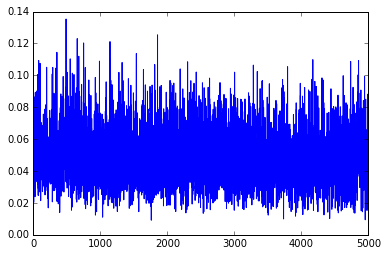

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))

Something is definitely getting learned. (some data lost when rerunning notebook)

# Limitations of the model

We have no control over transitions of `tf.nn.dynamic_rnn`, it is unrolled in a single sweep

- can't use beam search decoder optimization
- can't feed previously generated tokens without falling back to python loops
- can't use attention, because attention conditions decoder inputs on its previous state

Solution would be to use `tf.nn.raw_rnn` to reimplement relevant parts of `tf.nn.dynamic_rnn`, add attention and beam search loops.

## Test our model interractively

### Load from checkpoint

In [29]:
restore(sess)

INFO:tensorflow:Restoring parameters from checkpoint_directory/basic_seq2seq-40001


In [30]:
def prediction_feed(stc):
    length = len(stc)
    
    encoder_inputs_, _ = batch(
        ([stc])
    )
    decoder_inputs_, _ = batch(
        [[EOS] + [PAD] * (length+2)]
    )
    return {
        encoder_inputs: encoder_inputs_,
        decoder_inputs: decoder_inputs_
    }

### See how model performs with arbitrary data

In [35]:
try:
    while True:
        stc = encode(str(raw_input()))
        fd = prediction_feed(stc)
        predict_ = sess.run(decoder_prediction, fd)
        inp, pred = fd[encoder_inputs].T[0], predict_.T[0]
        print('    input     > {}'.format(form(decode(inp),'inp')))
        print('    predicted > {}'.format(form(decode(pred),'outp'))) 

except KeyboardInterrupt:
    print('testing interrupted')

currently executing fil
    input     > currently executing fil
    predicted > yltnerruc gnitucexe lif
who had long
    input     > who had long
    predicted > xhw dah gnol
same works correctly
    input     > same works correctly
    predicted > emas skrow yltcerroc
been around longer than
    input     > been around longer than
    predicted > neeb dnuora regnol naht
testing interrupted


In [ ]:
sess.close()